# Preprocess Signals from Vowels, Syllables and Sentences

In [24]:
#%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import scipy.io as sio
import numpy as np
from python_speech_features import mfcc
from vad import VAD
import csv

## 1. Load Vowel Data
Load one normal vowels (/a/ normal, /u/ normal, /i/ normal) but only using voice channels, the normal vowels are used for fitting the Hidden Markov Model, generate all hidden state distributions.

In [12]:
# Select Subject and Vowel
subject = "R031"
vowel = "a_normal"

In [13]:
# Extract variables that contain related data
vowel_data = sio.loadmat('Data/%s/%s.mat' % (subject, vowel))
noise_data = sio.loadmat('Data/%s/noise.mat' % subject)

# Load all raw data values for vowels
Tmp_Data = vowel_data['data']
Start = vowel_data['datastart']
End = vowel_data['dataend']
Sample_Rate = vowel_data['samplerate']
rep = Start.shape[1]
sample_rate = int(Sample_Rate[4,0])
print("Load Voice: %s" % vowel)
print("Total Repetitions: %d" % rep)
print("Sampling Rate: %d" % sample_rate)

Load Voice: a_normal
Total Repetitions: 55
Sampling Rate: 20000


In [ ]:
# Extract features from all 55 rep of voice signals
vowel_signal = []
length = []
plt.figure(figsize=(15, 25))
for rep in range(55):
    # ----- Extract the 2 channels voice signal -----
    voice_sample_channel = np.zeros((2*sample_rate, 2))
    
    # For the left channel
    # Get the indices for the current repetiton
    voice_start = int(Start[4,rep]) - 1
    voice_end = int(End[4,rep])
    # Extract and center the current voice signal
    voice_sample_tmp = Tmp_Data[0,voice_start:voice_end]
    voice_sample_channel[:,0] = voice_sample_tmp - np.mean(voice_sample_tmp)

    # For the right channel
    # Get the indices for the current repetiton
    voice_start = int(Start[5,rep]) - 1
    voice_end = int(End[5,rep])
    # Extract and center the current voice signal
    voice_sample_tmp = Tmp_Data[0,voice_start:voice_end]
    voice_sample_channel[:,1] = voice_sample_tmp - np.mean(voice_sample_tmp)

    # Combine from sterero into mono
    voice_sample = np.mean(voice_sample_channel, axis=1, 
                           dtype=voice_sample_channel.dtype)
    
    # ----- Detect voice activation -----
    # Apply VAD
    vad = VAD(voice_sample, sample_rate, 
              nFFT=512, win_length=0.025, 
              hop_length=0.01, theshold=0.99)
    if sum(vad) != 0:
        vad_post = vad.reshape(-1)
        vad_post = np.append([0], vad_post)
        vad_post = np.append(vad_post, [0])

        # peform the differentiation
        vad_detect = np.diff(vad_post)

        # Eliminate potential voice noise
        vad_start = []
        vad_end   = []
        # find non-zero elements +1/-1
        for i, v in enumerate(vad_detect):
            if v == 1:
                vad_start.append(i)
            elif v == -1:
                vad_end.append(i)

        # measure the length of each activation
        vad_delete = []
        for i, (s, e) in enumerate(zip(vad_start, vad_end)):
            if e - s < 10:
                vad_delete.append(i)

        vad_start = np.delete(vad_start, vad_delete, 0)
        vad_end = np.delete(vad_end, vad_delete, 0)

        i_start = int(vad_start[0]*0.01*sample_rate)
        i_end   = int((vad_end[0]*0.01+0.075)*sample_rate)   
        if i_end > 39999:
            i_end = 39999

        vowel_signal.append(voice_sample[range(i_start, i_end+1)])
        length.append(len(voice_sample[range(i_start, i_end+1)]))        
        
        plt.subplot(11, 5, rep+1)
        plt.plot(voice_sample[range(i_start, i_end+1)])
        plt.ylim((-0.03, 0.03))

plt.show()

55


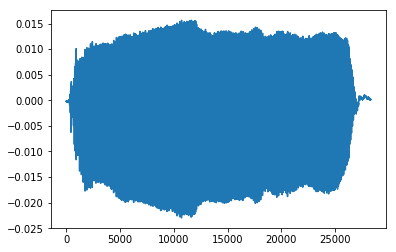

In [22]:
plt.plot(vowel_signal[0])
print(len(length))

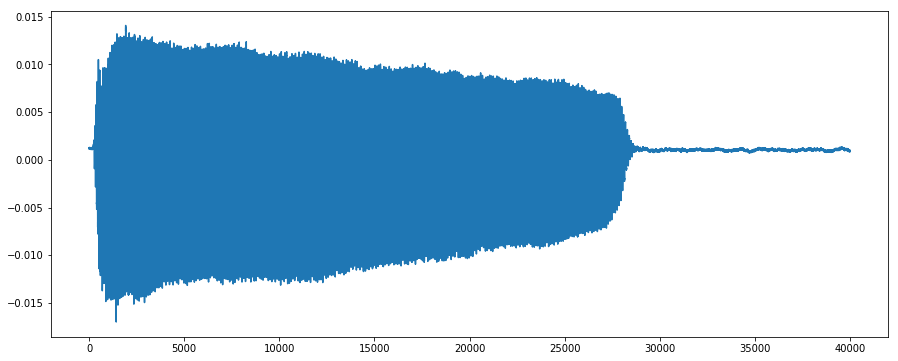

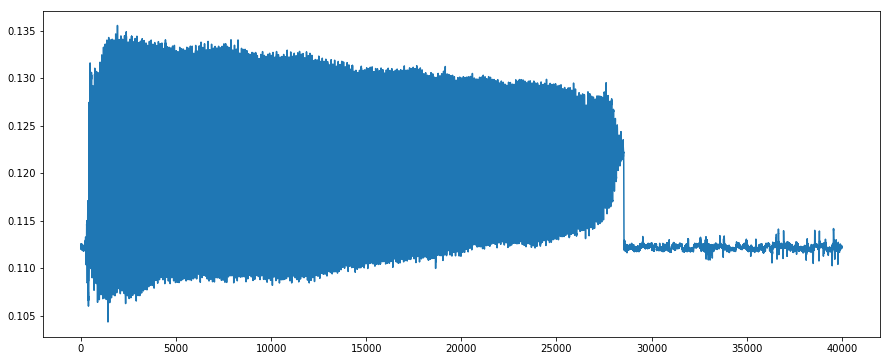

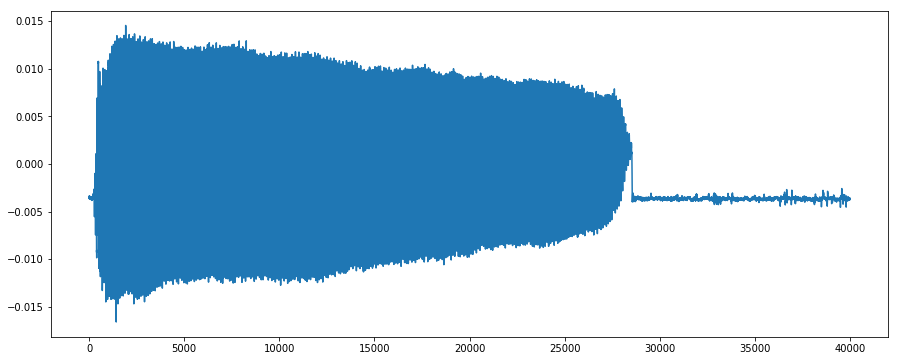

In [11]:
# Quick examine for individual signals
i = 50
# ----- Extract the 2 channels voice signal -----
voice_sample_channel = np.zeros((2*sample_rate, 2))

# For the left channel
# Get the indices for the current repetiton
voice_start = int(Start[4,i]) - 1
voice_end = int(End[4,i])
# Extract and center the current voice signal
voice_sample_tmp = Tmp_Data[0,voice_start:voice_end]
voice_sample_channel[:,0] = voice_sample_tmp - np.mean(voice_sample_tmp)

plt.figure(figsize=(15, 6))
plt.plot(voice_sample_tmp)
plt.show()

# For the right channel
# Get the indices for the current repetiton
voice_start = int(Start[5,i]) - 1
voice_end = int(End[5,i])
# Extract and center the current voice signal
voice_sample_tmp = Tmp_Data[0,voice_start:voice_end]
voice_sample_channel[:,1] = voice_sample_tmp - np.mean(voice_sample_tmp)

plt.figure(figsize=(15, 6))
plt.plot(voice_sample_tmp)
plt.show()

# Combine from sterero into mono
voice_sample = np.mean(voice_sample_channel, axis=1, 
                       dtype=voice_sample_channel.dtype)

# voice_sample = np.append(voice_sample[range(35000, 36000)], voice_sample)

plt.figure(figsize=(15, 6))
plt.plot(voice_sample)
plt.show()

In [9]:
# Detect voice activations
vad=VAD(voice_sample, sample_rate, nFFT=512, win_length=0.025, hop_length=0.01, theshold=0.99)

vad_post = vad.reshape(-1)
vad_post = np.append([0], vad_post)
vad_post = np.append(vad_post, [0])
print(vad_post)

# peform the differentiation
vad_detect = np.diff(vad_post)

# Eliminate potential voice noise
vad_start = []    # all start indices for the current state
vad_end   = []    # all end indices for the current state
# find non-zero elements +1/-1
for i, v in enumerate(vad_detect):
    if v == 1:
        vad_start.append(i)
    elif v == -1:
        vad_end.append(i)
    
print(vad_start, vad_end)

# measure the length of each activation
vad_delete = []
for i, (s, e) in enumerate(zip(vad_start, vad_end)):
    if e - s < 10:
        vad_delete.append(i)
    print(i)
    print(s, e)
print(vad_delete)

vad_start = np.delete(vad_start, vad_delete, 0)
vad_end = np.delete(vad_end, vad_delete, 0)

print(vad_start[0], vad_end[0])

i_start = int(vad_start[0]*0.01*sample_rate)
i_end   = int((vad_end[0]*0.01+0.075)*sample_rate)
if i_end > 39999:
    i_end = 39999
        
print(i_start, i_end)

plt.figure(figsize=(15, 6))
plt.plot(voice_sample[range(i_start, i_end+1)])
plt.show()

[0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[1, 6, 13] [5, 12, 14]
0
1 5
1
6 12
2
13 14
[0, 1, 2]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [25]:
# Save the pre-processed voice signals
with open("Data/%s/voice_%s_processed.csv" % (subject,vowel), "wb") as f:
    writer = csv.writer(f)
    writer.writerows(vowel_signal)

TypeError: a bytes-like object is required, not 'str'